In [3]:
import os
import urllib.request

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dbfread import DBF
from IPython.display import display
from ipywidgets import Output, RadioButtons, interact, widgets
from matplotlib import widgets
from matplotlib.widgets import RadioButtons
from ortools.linear_solver import pywraplp
from pandas import DataFrame

# Wind turbine optimization

## 0 - Importing data

In [4]:
"""
Load content of a DBF file into a Pandas data frame.

The iter() is required because Pandas doesn't detect that the DBF
object is iterable.

Loading the raw geospatial data into a Pandas data frame.

Datasource: https://www.swisstopo.admin.ch/en/home/meta/supply-structure/freely-available.html
"""

# Downloading a file from remote to a local file in a folder called Geospatial_raw_data_remote
dbf_url = 'https://github.com/percw/Swiss_wind-turbine_optimization/raw/b23d047c6f824bb225cc1b7d5aa559166f191ec6/Geospatial_raw_data/spat_pts/spat_pts.dbf'
shape_url = 'https://github.com/percw/Swiss_wind-turbine_optimization/raw/b23d047c6f824bb225cc1b7d5aa559166f191ec6/Geospatial_raw_data/spat_pts/spat_pts.shp'


# Checking if the folder Geospatial_raw_data exists, if not: downloading the files from remote
if not os.path.exists('./Geospatial_raw_data/'):
	os.makedirs('./Geospatial_raw_data/spat_pts/')
	urllib.request.urlretrieve(dbf_url, './Geospatial_raw_data/spat_pts.dbf') 		# Loading the .dbf file
	urllib.request.urlretrieve(shape_url, './Geospatial_raw_data/spat_pts.shp') 	# Loading the .shp file

# Loading the file from local to Geopandas and Pandas data frame
dbf = DBF('./Geospatial_raw_data/spat_pts.dbf', encoding='UTF-8')
gdf = gpd.read_file('./Geospatial_raw_data/spat_pts.shp')
df_dbf_raw = DataFrame(iter(dbf))



File: `spat_pts.dbf` - consists of candidate wind turbine locations in Switzerland which are technically feasible. The readme file provides details about the 30 attributes further attributes and the coordinate reference system. 

In [3]:
print(df_dbf_raw.head(10))
#print(df_shp_raw.head(10))

# Displaying the column names of the dbf file
print(df_dbf_raw.columns)

    PU_ID   LT  WT_ID  DIST_ISOS  DIST_UNE_N  DIST_UNE_K  DIST_BLN  DIST_VAEW  \
0   738.0  1.0    9.0      735.0    132448.0     16505.0     184.0   115789.0   
1   880.0  1.0   11.0      567.0    132177.0     16475.0     382.0   115340.0   
2   881.0  1.0   12.0      186.0    131844.0     15740.0     156.0   115343.0   
3  1021.0  1.0   15.0      424.0    131912.0     16340.0     389.0   114896.0   
4  1163.0  1.0   20.0     1288.0    131652.0     16255.0     349.0   114458.0   
5  1449.0  1.0   24.0      767.0    130084.0     14166.0     412.0   113543.0   
6  1586.0  1.0   25.0      940.0    131307.0     17251.0     650.0   113249.0   
7  1589.0  1.0   28.0     1856.0    130159.0     14700.0     223.0   113097.0   
8  1590.0  1.0   29.0      636.0    129811.0     14094.0     387.0   113089.0   
9  1591.0  1.0   30.0      847.0    129481.0     13388.0     225.0   113102.0   

   DIST_RAD  DIST_AIR  ...  COHER_AREA  VIS_ARE_ha  ENER_DENS     DIST_NATPA  \
0   26065.0    2861.0  ...  

## 1 - Discovering the data 

In [4]:

print(f'Number of technically possible wind turbine locations: {len(df_dbf_raw["PU_ID"].unique())}')
print(f'Number of canton where its feasible to place wind turbine: {len(df_dbf_raw["CANT_NAME"].unique())}')
print(f'The cantons are: {df_dbf_raw["CANT_NAME"].unique()}')

Number of technically possible wind turbine locations: 12238
Number of canton where its feasible to place wind turbine: 27
The cantons are: ['GenÃ¨ve' 'Vaud' 'NeuchÃ¢tel' 'Fribourg' 'Valais' 'Bern' 'Jura'
 'Solothurn' 'Basel-Landschaft' 'Basel-Stadt' 'Aargau' 'Luzern' 'Obwalden'
 'Nidwalden' 'ZÃ¼rich' 'Zug' 'Schaffhausen' 'Schwyz' 'Uri' 'Thurgau'
 'Ticino' 'St. Gallen' 'Glarus' 'GraubÃ¼nden' 'Appenzell Ausserrhoden'
 'Appenzell Innerrhoden' '']


Checking out the canton with the empty string

In [5]:
display(df_dbf_raw[df_dbf_raw["CANT_NAME"] == ''])

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,COHER_AREA,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME
11483,44486.0,3.0,90016.0,4448.0,103730.0,25509.0,1211.0,118303.0,110823.0,4602.0,...,0.060856,16516.0,0.17994,240473.993717,884.0,0.0,669.999901,8173.304396,4.0,


Investigating the shapefile

In [6]:
display(gdf.columns)
display(gdf.head())

Index(['PU_ID', 'LT', 'WT_ID', 'DIST_ISOS', 'DIST_UNE_N', 'DIST_UNE_K',
       'DIST_BLN', 'DIST_VAEW', 'DIST_RAD', 'DIST_AIR', 'DIST_MIL',
       'DIST_FLOOD', 'DIST_MEAD', 'DIST_JB', 'DIST_BIOS', 'DIST_STRE',
       'DIST_FOR', 'DIST_HZ', 'DIST_IZ', 'DIST_PL', 'DIST_BUILD', 'ALTI',
       'NOISE', 'FFF', 'VIS_AREA', 'VIS_IMPACT', 'VIS_INFRA', 'VIS_POP',
       'COHER_AREA', 'VIS_ARE_ha', 'ENER_DENS', 'DIST_NATPA', 'STRE_ALTI',
       'DIST_REG_N', 'weigh_stre', 'prod_MW', 'KIBK', 'CANT_NAME', 'geometry'],
      dtype='object')

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry
0,738.0,1.0,9.0,735.0,132448.0,16505.0,184.0,115789.0,26065.0,2861.0,...,28132.0,0.405058,314835.059489,457.0,24717.649525,219.999966,11395.094829,4.0,GenÃ¨ve,POINT (487660.175 118136.448)
1,880.0,1.0,11.0,567.0,132177.0,16475.0,382.0,115340.0,26638.0,1965.0,...,29088.0,0.400389,314505.331052,455.0,25089.914492,111.000053,11646.518761,4.0,GenÃ¨ve,POINT (488110.175 117357.025)
2,881.0,1.0,12.0,186.0,131844.0,15740.0,156.0,115343.0,25176.0,3242.0,...,27704.0,0.397480,314276.488429,432.0,23823.745962,160.000017,11011.797909,2.0,GenÃ¨ve,POINT (488110.175 118915.871)
3,1021.0,1.0,15.0,424.0,131912.0,16340.0,389.0,114896.0,27229.0,1068.0,...,28600.0,0.395229,314177.833777,419.0,25488.529743,111.000031,11303.539758,1.0,GenÃ¨ve,POINT (488560.175 116577.603)
4,1163.0,1.0,20.0,1288.0,131652.0,16255.0,349.0,114458.0,27836.0,171.0,...,28680.0,0.417131,313852.574631,377.0,25912.279012,785.999983,11963.309177,3.0,GenÃ¨ve,POINT (489010.175 115798.180)


## 2 - Visualisation

Creating subplot maps over the different columns to show how the different characteristics such as power, closest distance to nearest house etc for the technically plausible wind turbine locations in Switzerland looks like.

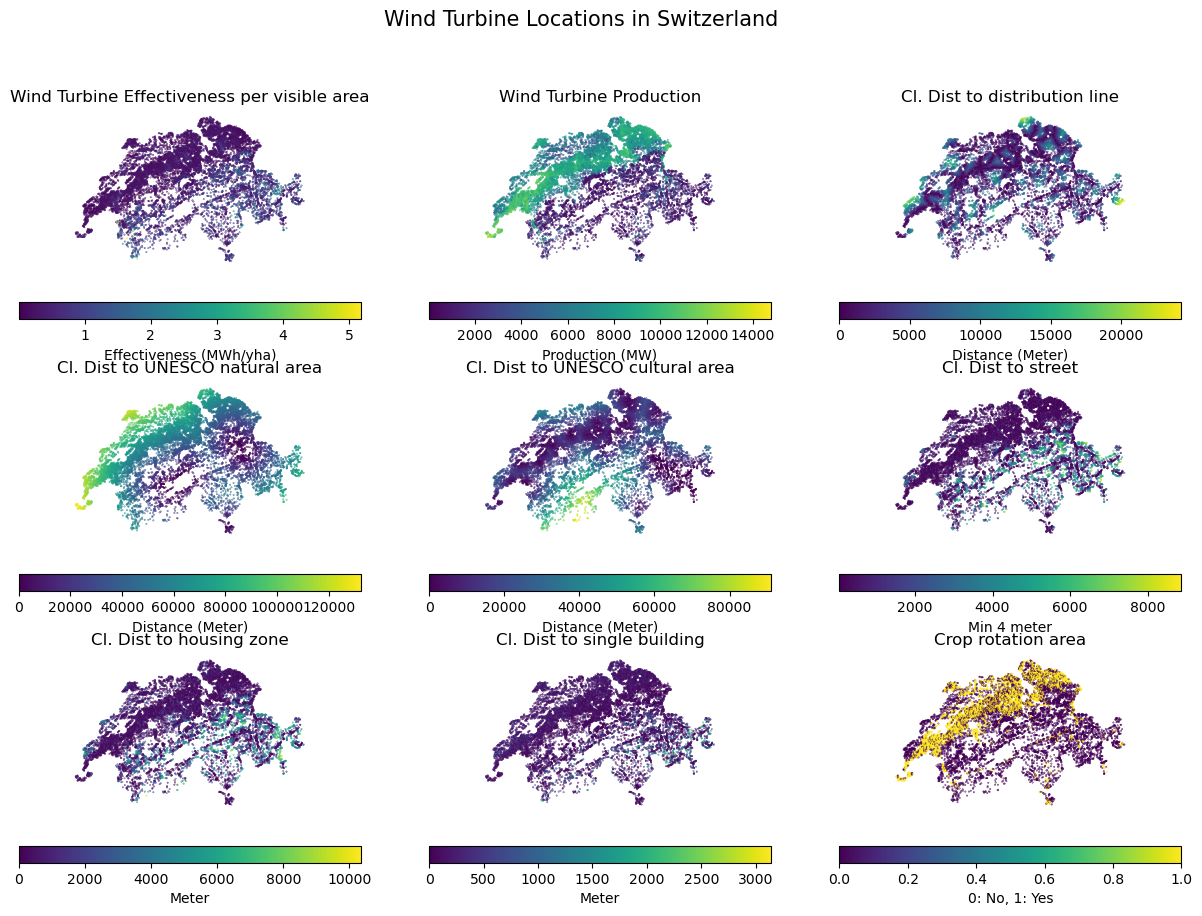

In [7]:

def create_subplot(gdf, columns, labels, titles, main_title, markersize=0.1, cmap='viridis', figsize=(15, 10)):
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()  # flatten the 2D array to 1D for easier looping

    # log format the subplot coming from column 'ENER_DENS'

    for i in range(len(columns)):
        gdf.plot(column=columns[i], ax=axes[i], markersize=markersize, cmap=cmap, legend=True, legend_kwds={
            'label': labels[i], 'orientation': "horizontal"})
        axes[i].set_title(titles[i])
        axes[i].set_axis_off()

    if main_title:  # add a main title to the figure if provided
        fig.suptitle(main_title, size=15)


# Calling function to create a subplot
columns = ['ENER_DENS', 'prod_MW', 'DIST_PL', 'DIST_UNE_N', 'DIST_UNE_K',
           'DIST_STRE', 'DIST_HZ', 'DIST_BUILD', 'FFF']
labels = ["Effectiveness (MWh/yha)", "Production (MW)", "Distance (Meter)", "Distance (Meter)", "Distance (Meter)", "Min 4 meter",
          "Meter", "Meter", "0: No, 1: Yes"]
titles = ["Wind Turbine Effectiveness per visible area", "Wind Turbine Production", "Cl. Dist to distribution line",
          "Cl. Dist to UNESCO natural area", "Cl. Dist to UNESCO cultural area",
          "Cl. Dist to street", "Cl. Dist to housing zone", "Cl. Dist to single building", "Crop rotation area"]

create_subplot(gdf, columns, labels, titles,
               main_title="Wind Turbine Locations in Switzerland")


Plotting a correlation matrix between the different parameters

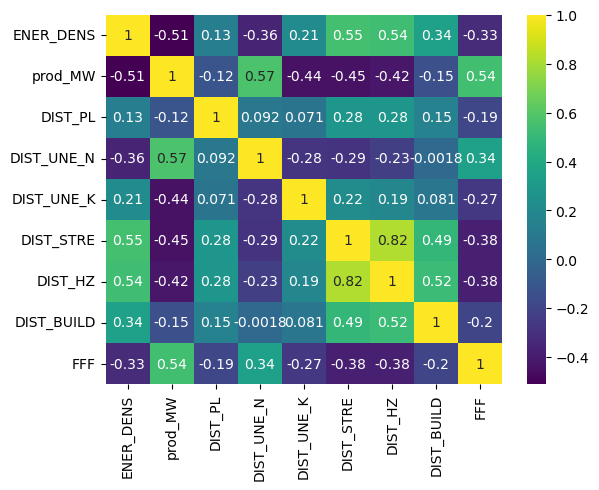

In [8]:

corr = gdf[columns].corr()

sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()


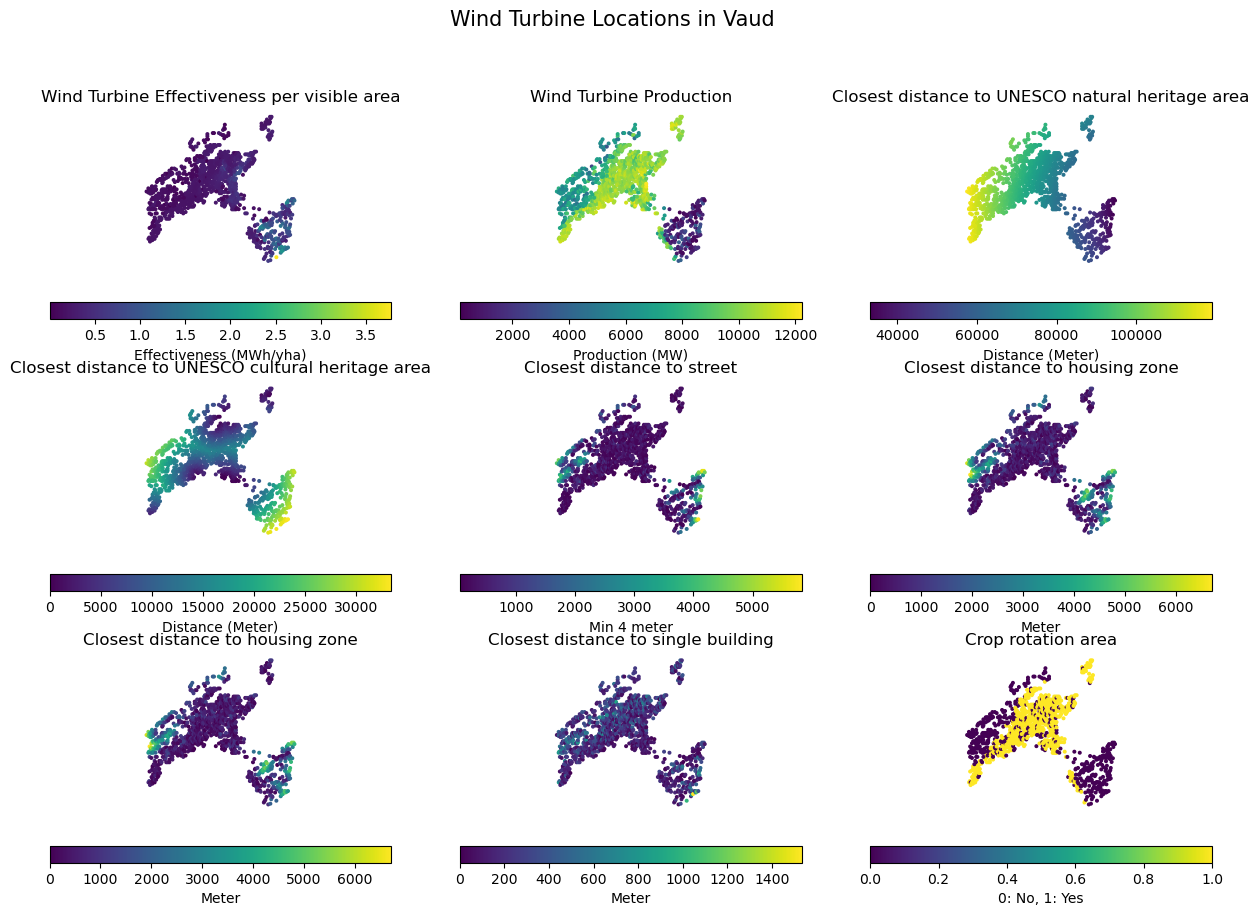

In [9]:
# Creating a figure with six subplots

gdf_vaud = gdf[gdf['CANT_NAME'] == 'Vaud'].copy()

# Calling function to create a subplot
columns = ['ENER_DENS', 'prod_MW', 'DIST_UNE_N', 'DIST_UNE_K',
           'DIST_STRE', 'DIST_HZ', 'DIST_HZ', 'DIST_BUILD', 'FFF']
labels = ["Effectiveness (MWh/yha)", "Production (MW)", "Distance (Meter)", "Distance (Meter)", "Min 4 meter",
          "Meter", "Meter", "Meter", "0: No, 1: Yes"]
titles = ["Wind Turbine Effectiveness per visible area", "Wind Turbine Production",
          "Closest distance to UNESCO natural heritage area", "Closest distance to UNESCO cultural heritage area",
          "Closest distance to street", "Closest distance to housing zone",
          "Closest distance to housing zone", "Closest distance to single building", "Crop rotation area"]

create_subplot(gdf_vaud, columns, labels, titles,
               main_title="Wind Turbine Locations in Vaud", markersize=3.5)


In [10]:
gdf_vaud

,PU_ID,LT,WT_ID,DIST_ISOS,DIST_UNE_N,DIST_UNE_K,DIST_BLN,DIST_VAEW,DIST_RAD,DIST_AIR,...,VIS_ARE_ha,ENER_DENS,DIST_NATPA,STRE_ALTI,DIST_REG_N,weigh_stre,prod_MW,KIBK,CANT_NAME,geometry
35,4581.0,1.0,145.0,4434.0,118209.0,5342.0,103.0,104465.0,11379.0,4026.0,...,55364.0,0.192633,301086.863909,477.0,7094.380529,320.999912,10664.948813,4.0,Vaud,POINT (499810.175 131386.637)
39,4723.0,1.0,157.0,4298.0,117667.0,5896.0,97.0,104089.0,10748.0,4419.0,...,54672.0,0.196790,300554.319018,480.0,6206.756382,375.999960,10758.880055,4.0,Vaud,POINT (500260.175 132166.060)
43,4864.0,1.0,165.0,3393.0,117526.0,3550.0,1827.0,103423.0,13117.0,2626.0,...,59084.0,0.192743,300367.913389,446.0,8342.530869,362.999912,11388.028438,4.0,Vaud,POINT (500710.175 129827.791)
44,4865.0,1.0,166.0,3575.0,117317.0,5012.0,874.0,103569.0,11627.0,3585.0,...,57224.0,0.191794,300192.454416,470.0,6821.864033,164.000053,10975.196267,3.0,Vaud,POINT (500710.175 131386.637)
46,5006.0,1.0,173.0,2951.0,116973.0,4136.0,1657.0,103054.0,12509.0,2751.0,...,58612.0,0.191944,299832.314387,443.0,7494.774097,661.999978,11250.204831,4.0,Vaud,POINT (501160.175 130607.214)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11330,36562.0,3.0,89751.0,2745.0,61724.0,1331.0,3827.0,55420.0,50186.0,16704.0,...,24480.0,0.145225,244131.293467,745.0,5423.218020,497.000249,9394.227855,4.0,Vaud,POINT (555410.175 149226.760)
11331,36568.0,3.0,89752.0,2370.0,62483.0,7420.0,9610.0,59265.0,52647.0,15800.0,...,20920.0,0.166220,243777.716939,763.0,10409.842289,289.999778,9179.784796,5.0,Vaud,POINT (555410.175 156501.374)
11373,39482.0,3.0,89822.0,4388.0,56131.0,6212.0,6318.0,50583.0,44827.0,14135.0,...,11352.0,0.169946,238543.024396,1183.0,1502.355779,1082.999794,5778.522468,5.0,Vaud,POINT (561010.175 149226.760)
11379,39661.0,3.0,89829.0,2453.0,55726.0,6901.0,3053.0,48170.0,43371.0,14340.0,...,19956.0,0.116278,238507.382222,1103.0,0.000000,877.999086,6747.197416,1.0,Vaud,POINT (561360.175 144983.236)


## 3 Optimization

### 3.1 Minimizing the number of wind turbines while reaching 1.2TWh per year in total production

#### General motivation for minimizing the number of wind turbines

In the process of transitioning to more sustainable and renewable energy sources, the placement and number of wind turbines is a critical decision with both economic and environmental implications. Our primary goal is to meet the projected energy demand in 2035, which is estimated to be 1.2 TWh per year. However, in addressing this objective, we have to consider other important factors.

Firstly, it's important to minimize the number of wind turbines because each turbine represents not only a significant financial investment but also a physical intrusion into the landscape. Turbines can have visual and auditory impacts on the surrounding communities, and they can affect local wildlife, particularly bird and bat populations. By minimizing the number of turbines, we aim to reduce these potential negative impacts.

Secondly, the infrastructure required for wind turbines is considerable. Each turbine needs to be connected to the power grid, which may require building new transmission lines. Additionally, roads may need to be constructed or upgraded to allow for the transportation of turbine components and ongoing maintenance. By minimizing the number of turbines, we can reduce the extent of this necessary infrastructure and potentially lessen environmental disruption and costs.

Finally, the fewer turbines we use to meet the energy demand, the more efficient our solution. If we can meet our energy targets with fewer turbines, it means that we're making the most of the wind resources available, and our solution is economically and environmentally efficient.

Hence, the optimization problem that we are solving is not merely an academic exercise but a real-world problem with tangible implications for the economy, the environment, and society. It involves balancing the need for renewable energy with the desire to minimize the impact on the environment and communities. By formulating this as a binary integer programming problem, we can use powerful computational tools to find the optimal solution, aiding decision-makers in their task.



#### Problem Formulation 

This document provides a mathematical formulation for a specific optimization problem. The problem aims to minimize the number of wind turbines while ensuring a total power production of at least 1.2 TWh/yha.

#### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

#### Constraints 

The problem has a constraint on the total power production. The sum of the power production from all locations where wind turbines are placed should be at least 1.2 TWh/yha. 

Let $p_{i}$ represent the power production in MW from location $i$.

This can be mathematically represented as:

$\sum_{i \in I} x_{i} * p_{i} \geq 1200000$

#### Objective Function 

The objective is to minimize the total number of wind turbines, which is equivalent to the sum of the decision variables $x_{i}$.

This can be mathematically represented as:

$Minimize: \sum_{i \in I} x_{i}$

#### Solution 

The solution is a vector $x$ that satisfies the constraint and minimizes the objective function. If there is no such vector, the problem does not have an optimal solution.

In [80]:
def create_solver_for_wind_turbine_optimization(gdf, min_total_prod):
    # 1. Set up the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # 2. Define decision variables
    x = {}
    for i in range(len(gdf)):
        x[i] = solver.IntVar(0, 1, '')

    # 3. Define the constraint: total production should be min_total_prod or more
    solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= min_total_prod)

    # 4. Define the objective function. 
    # Objective function: Minimize the number of wind turbines
    solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

    return solver, x

def get_solutions_for_wind_turbine_optimization(solver, gdf, x):
    status = solver.Solve()

    # 6. Print the solution
    if status == pywraplp.Solver.OPTIMAL:
        selected_locations = []
        total_output = 0
        for i in range(len(gdf)):
            if x[i].solution_value() > 0:
                selected_locations.append(gdf.iloc[i]['geometry'])
                total_output = total_output + gdf.iloc[i]['prod_MW']
        print(f'Number of wind turbines needed: {len(selected_locations)}')
        print(f'Total power output: {total_output} MWh/y')
        print(f'Average power output: {total_output/len(selected_locations)} MWh/y')
        solver.Clear()
        return selected_locations
    else:
        print('The problem does not have an optimal solution.')
        solver.Clear()
        return None

solver, x = create_solver_for_wind_turbine_optimization(gdf, 1200000)
minimum_wind_turbine_locations = get_solutions_for_wind_turbine_optimization(solver, gdf, x)


Number of wind turbines needed: 101
Total power output: 1209160.3346111062 MWh/y
Average power output: 11971.884501100061 MWh/y


Now, we can use the same function and exclude all the areas where theres currently crop rotation

In [88]:
solver_no_crop, x = create_solver_for_wind_turbine_optimization(gdf, 1200000)

# Adding constraint so that every crop rotation location is set to zero
for i in range(len(gdf)):
    if gdf.FFF[i] == 1:
        solver_no_crop.Add(x[i] == 0)
        
minimum_wind_turbine_locations_no_crop = get_solutions_for_wind_turbine_optimization(solver_no_crop, gdf, x)


Number of wind turbines needed: 108
Total power output: 1203876.3280057383 MWh/y
Average power output: 11147.00303709017 MWh/y


Text(0.5, 1.0, 'Minimum number Wind Turbine and their locations in Switzerland')

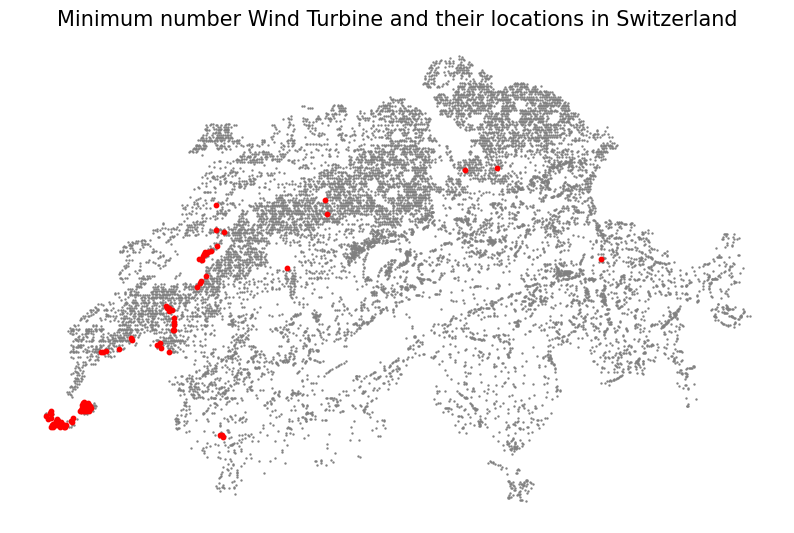

In [89]:
# Creating a new GeoDataFrame from selected locations
selected_gdf = gpd.GeoDataFrame(geometry=minimum_wind_turbine_locations)

# Ploting the selected locations on the map
ax = gdf.plot(color='grey', markersize=0.5, figsize=(10,10))
selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# Removing axis labels
ax.set_axis_off()

# Setting title
ax.set_title('Minimum number Wind Turbine and their locations in Switzerland', size=15)

Text(0.5, 1.0, 'Minimum number Wind Turbine and their locations (excluding crop area) in Switzerland')

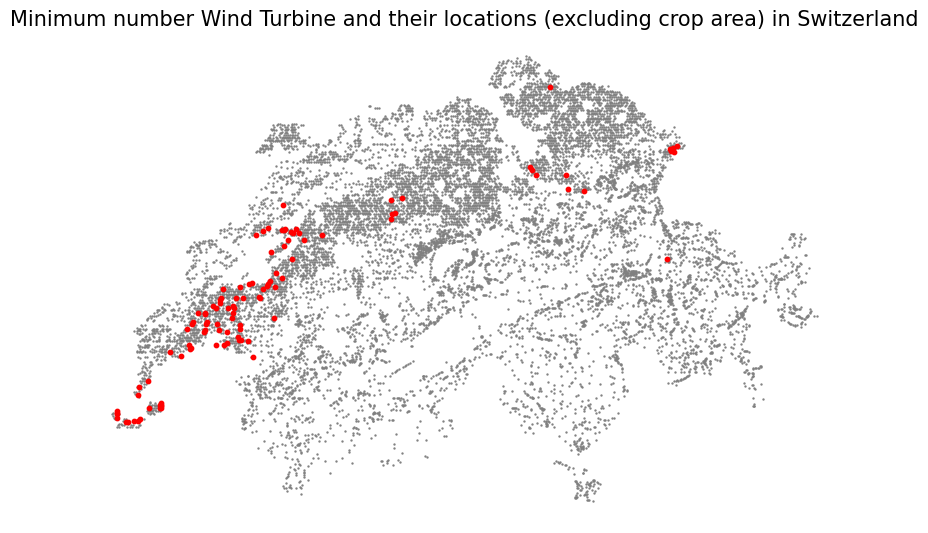

In [90]:
# Creating a new GeoDataFrame from selected locations
selected_gdf = gpd.GeoDataFrame(geometry=minimum_wind_turbine_locations_no_crop)

# Ploting the selected locations on the map
ax = gdf.plot(color='grey', markersize=0.5, figsize=(10,10))
selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# Removing axis labels
ax.set_axis_off()

# Setting title
ax.set_title('Minimum number Wind Turbine and their locations (excluding crop area) in Switzerland', size=15)

### 3.2. Additional constraints

Now, we can play with different constraints to see how the map changes.

#### Problem Formulation 

This document provides a mathematical formulation for a specific optimization problem. The problem aims to optimize the placement of wind turbines considering various constraints such as energy production, distance to UNESCO heritage areas, distance to housing zones, distance to transmission, and crop rotation areas.

#### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

#### Constraints 

The problem has several constraints:

**All choices should meet the energy demand of 1.2 TWh/year or more**

This constraint ensures that the total power produced by all selected wind turbines is at least 1.2 TWh per year. Let $p_{i}$ represent the power production in MW from location $i$. This can be mathematically represented as:

   $\sum_{i \in I} x_{i} * p_{i} \geq 1.2 * 10^6$

The other additional constraints that can be interactively changed are:

1. **Distance to Unesco heritage area should be more or equal to 2000m (2km)**

   This constraint ensures that no wind turbines are selected that are within 5km of a Unesco heritage area. Let $d_{UNE,i}$ represent the distance to the nearest Unesco heritage area from location $i$. This can be mathematically represented as:

   If $d_{UNE,i} < 3000$, then $x_{i} = 0$

2. **Distance to housing zone area should be more or equal to 1000m (1km)**

   This constraint ensures that no wind turbines are selected that are within 2km of a housing zone area. Let $d_{HZ,i}$ represent the distance to the nearest housing zone from location $i$. This can be mathematically represented as:

   If $d_{HZ,i} < 2000$, then $x_{i} = 0$

3. **Distance to transmission should be less or equal to 1500m (1,5km)**

   This constraint ensures that no wind turbines are selected that are more than 1km from a transmission line. Let $d_{PL,i}$ represent the distance to the nearest transmission line from location $i$. This can be mathematically represented as:

   If $d_{PL,i} > 1000$, then $x_{i} = 0$

4. **Avoid crop rotation area**

   This constraint ensures that no wind turbines are selected that are located in a crop rotation area. Let $f_{i}$ represent whether location $i$ is a crop rotation area or not. This can be mathematically represented as:

   If $f_{i} = 1$, then $x_{i} = 0$

#### Objective Function 

The objective is to maximize the total energy density minus a trade-off factor. Let $e_{i}$ represent the energy density at location $i$ and $t$ represent the trade-off factor. This can be mathematically represented as:

$Maximize: \sum_{i \in I} (e_{i} - t) * x_{i}$

#### Solution 

The solution is a vector $x$ that satisfies the constraints and maximizes the objective function. If there is no such vector, the problem does not have an optimal solution.

Dropdown(description='Constraint:', options=(('Distance to Unesco heritage area should be more or equal to 200…

Button(button_style='info', description='Optimize', style=ButtonStyle(), tooltip='Click to optimize wind turbi…

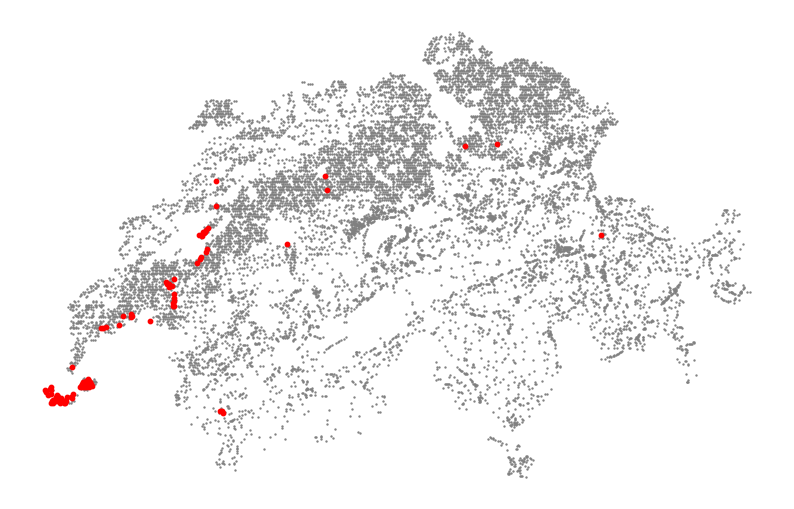

Number of wind turbines needed: 101
Power output: 1205460.1846224747 MWh/year
Avg. power output: 11935.249352697769 MWh/year per wind turbine


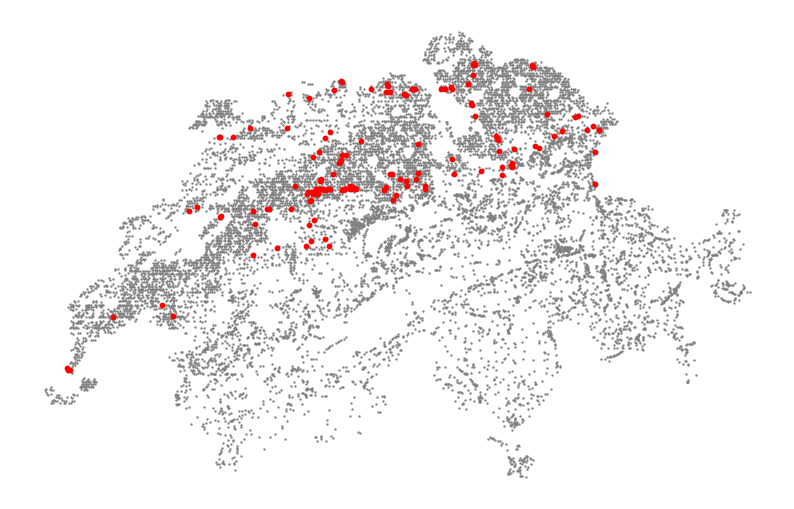

Number of wind turbines needed: 139
Power output: 1202007.7234753293 MWh/year
Avg. power output: 8647.537578959204 MWh/year per wind turbine


In [96]:

def apply_constraints(solver, constraint_choice, gdf, x, unesco_treshhold, housing_treshhold, transmission_treshhold):
    """Applies constraints to the solver based on user's choice."""

    # Total production should be 1.2 TWh/yha or more for all constraints
    solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000)

    if constraint_choice == '1':
        # Distance to Unesco heritage area should be more or equal to 2000m (2km)
        for i in range(len(gdf)):
            if gdf.DIST_UNE_N[i] < unesco_treshhold or gdf.DIST_UNE_K[i] < unesco_treshhold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '2':
        # Distance to housing zone area should be more or equal to 1000m (1km)
        for i in range(len(gdf)):
            if gdf.DIST_HZ[i] < housing_treshhold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '3':
        # Distance to transmission should be less or equal to 1500m (1.5km)
        for i in range(len(gdf)):
            if gdf.DIST_PL[i] > transmission_treshhold:
                solver.Add(x[i] == 0)

    elif constraint_choice == '4':
        # Avoid crop rotation area
        for i in range(len(gdf)):
            if gdf.FFF[i] == 1:
                solver.Add(x[i] == 0)

    elif constraint_choice == '5':
        # Include all constraints
        for i in range(len(gdf)):
            if gdf.DIST_UNE_N[i] < unesco_treshhold or gdf.DIST_UNE_K[i] < unesco_treshhold:
                solver.Add(x[i] == 0)
            if gdf.DIST_HZ[i] < housing_treshhold:
                solver.Add(x[i] == 0)
            if gdf.DIST_PL[i] > transmission_treshhold:
                solver.Add(x[i] == 0)
            if gdf.FFF[i] == 1:
                solver.Add(x[i] == 0)


def optimize_wind_turbine_placement(b):
    """Optimizes wind turbine placement based on constraints."""

    # Set up the solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define decision variables
    x = {i: solver.IntVar(0, 1, '') for i in range(len(gdf))}

    # Define the constraints based on user's choice
    constraint_choice = dropdown.value
    apply_constraints(solver, constraint_choice, gdf, x, unesco_treshhold, housing_treshhold, transmission_treshhold)

    # Define the objective function: Minimize the number of wind turbines
    solver.Minimize(solver.Sum(x[i] for i in range(len(gdf))))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        selected_locations = [gdf.iloc[i]['geometry']
                              for i in range(len(gdf)) if x[i].solution_value() > 0]

        # create a new GeoDataFrame from selected locations
        selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

        # plot the selected locations on the map
        ax = gdf.plot(color='grey', markersize=0.5, figsize=(10, 10))
        selected_gdf.plot(ax=ax, marker='o', color='red', markersize=10)

        # removing axis on the plot
        ax.axis('off')
        plt.show()
        
        num_turbines = len(selected_locations)
        total_output = sum(gdf.iloc[i]['prod_MW'] for i in range(
            len(gdf)) if x[i].solution_value() > 0)
        print(f'Number of wind turbines needed: {num_turbines}')
        print(f'Power output: {total_output} MWh/year')
        print(f'Avg. power output: {total_output/num_turbines} MWh/year per wind turbine')
    else:
        print('The problem does not have an optimal solution.')

unesco_treshhold = 2000
housing_treshhold = 1000
transmission_treshhold = 1500

# Create dropdown menu
dropdown = widgets.Dropdown(options=[
    (f'Distance to Unesco heritage area should be more or equal to {unesco_treshhold}m', '1'),
    (f'Distance to housing zone area should be more or equal to {housing_treshhold}m ', '2'),
    (f'Distance to transmission should be less or equal to {transmission_treshhold}', '3'),
    ('Avoid crop rotation area', '4'),
    ('All constraints above', '5'),
],
    value='1',
    description='Constraint:',
)

button = widgets.Button(
    description='Optimize',
    button_style='info',   # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to optimize wind turbine placement',
)

def on_button_clicked(b):
    optimize_wind_turbine_placement(dropdown.value)

button.on_click(on_button_clicked)
display(dropdown, button)

# Execute the optimization for the default choice
optimize_wind_turbine_placement(dropdown.value)


### 3.3 Maximizing the energy output per visible area

### Problem Formulation 

This document provides a mathematical formulation for a specific optimization problem. The problem aims to minimize the number of wind turbines and maximize the energy density (ENER_DENS) while ensuring a total power production of at least 1.2 TWh/year. 

### Decision Variables 

Let's denote the binary decision variables with the letter $x$. Each $x_{i}$ represents whether a wind turbine is placed at location $i$ or not. If a wind turbine is placed at location $i$, $x_{i}$ will be 1, otherwise, it will be 0.

$x_{i} \in \{0, 1\}$ for each $i \in I$, where $I$ is the set of all locations.

### Constraints 

The problem has a constraint on the total power production. The sum of the power production from all locations where wind turbines are placed should be at least 1.2 TWh/y. 

Let $p_{i}$ represent the power production in MW from location $i$.

This can be mathematically represented as:

$\sum_{i \in I} x_{i} * p_{i} \geq 1200000$

### Objective Function 

The objective is to minimize the number of wind turbines and maximize the energy density (ENER_DENS). If $d_{i}$ represents the energy density at location $i$, and $λ$ represents the trade-off weight, this can be mathematically represented as:

$Maximize: \sum_{i \in I} (-d_{i} + λ) * x_{i}$

In our case, we can set $λ$ to be different values, to display the trade-off between the two objectives. For the code below we have chosen the following:

$λ \in \{0.01, 0.025, 0.05, 0.1, 0.2, 0.3\}$

### Solution 

The solution of the problem is a vector $x$ that satisfies the constraint and maximizes the objective function. If there is no such vector, the problem does not have an optimal solution.

In [50]:
def optimize_wind_turbine_placement_on_enr_dens(gdf, trade_offs):
    selected_locations = []
    print(f'\n\nOptimizing for trade-offs = {trade_offs}')

    for trade_off in trade_offs:
        print(f'\nOptimization results for trade-off = {trade_off}')
        print('------------------------------------------')

        # 1. Set up the solver
        solver = pywraplp.Solver.CreateSolver('SCIP')
        # 2. Define decision variables
        x = {}
        for i in range(len(gdf)):
            x[i] = solver.IntVar(0, 1, '')

        # 3. Define the constraint : total production should be 1.2 TWh/yha or more
        solver.Add(sum(x[i] * gdf.prod_MW[i] for i in range(len(gdf))) >= 1200000)

        # 4. Define the objective function
        objective = solver.Objective()
        for i in range(len(gdf)):
            objective.SetCoefficient(x[i], -gdf.ENER_DENS[i] + trade_off * 1)
        objective.SetMaximization()

        status = solver.Solve()

        # 6. Print the solution
        if status == pywraplp.Solver.OPTIMAL:
            selected_locations_enr_dens = []
            total_output = 0
            total_energy_density = 0
            for i in range(len(gdf)):
                if x[i].solution_value() > 0:
                    selected_locations_enr_dens.append(gdf.iloc[i]['geometry'])
                    total_output += gdf.iloc[i]['prod_MW']
                    total_energy_density += gdf.iloc[i]['ENER_DENS']
            print(
                f'Number of wind turbines needed: {len(selected_locations_enr_dens)}')
            print(f'Total power output: {total_output} MWh')
            print(f'Total energy density: {total_energy_density}')
            selected_locations.append(selected_locations_enr_dens)
        else:
            print('The problem does not have an optimal solution.')
    return selected_locations

trade_offs = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]
selected_locations_enr_dens = optimize_wind_turbine_placement_on_enr_dens(gdf, trade_offs=trade_offs)



Optimizing for trade-offs = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3]

Optimization results for trade-off = 0.01
------------------------------------------
Number of wind turbines needed: 176
Total power output: 1200030.0208428437 MWh
Total energy density: 10.718528990199998

Optimization results for trade-off = 0.025
------------------------------------------
Number of wind turbines needed: 186
Total power output: 1200068.3434990316 MWh
Total energy density: 10.8936698902

Optimization results for trade-off = 0.05
------------------------------------------
Number of wind turbines needed: 201
Total power output: 1200038.1181240024 MWh
Total energy density: 11.475980290199997

Optimization results for trade-off = 0.1
------------------------------------------
Number of wind turbines needed: 345
Total power output: 1946330.5657476129 MWh
Total energy density: 24.315010390199987

Optimization results for trade-off = 0.2
------------------------------------------
Number of wind turbines needed:

We can visualize the findings using a interactive map

In [69]:
from ipywidgets import widgets

def show_map(trade_off):
    # Find the index of the trade_off in the trade_offs list
    index = trade_offs.index(trade_off)
    
    # Use the index to access the corresponding element in the selected_locations_enr_dens list
    selected_locations = selected_locations_enr_dens[index]
    
    # Create a new GeoDataFrame from selected locations
    selected_gdf = gpd.GeoDataFrame(geometry=selected_locations)

    # Plot the selected locations on the map
    ax = gdf.plot(color='grey', markersize=0.5, figsize=(10, 10))
    selected_gdf.plot(ax=ax, marker='o', color='red', markersize=5)

    # Setting title
    ax.set_title('Wind Turbine Locations with the highest energy density per visible hectare', size=15)
    
    # Removing axis on the plot
    ax.axis('off')
    plt.show()

    # Calculate key characteristics of the solution
    number_of_turbines = len(selected_locations)
    power_output = sum(gdf.iloc[i]['prod_MW'] for i in range(len(gdf)) if gdf.iloc[i]['geometry'] in selected_locations)
    energy_density = sum(gdf.iloc[i]['ENER_DENS'] for i in range(len(gdf)) if gdf.iloc[i]['geometry'] in selected_locations)
    avg_energy_output = power_output / number_of_turbines

    # Print the key characteristics of the solution
    print(f'Number of wind turbines needed: {number_of_turbines}')
    print(f'Power output: {power_output} MWh/year')
    print(f'Avg power output: {avg_energy_output} MWh/year')
    print(f'Energy density: {energy_density} MWh/year/ha')

# Create a dropdown widget for the trade-offs
dropdown = widgets.Dropdown(options=trade_offs,
                            # Setting dropbdown style
    value=trade_offs[0],
    description='Trade-off',
)


# Use interact to create the user interface
interact(show_map, trade_off=dropdown)


interactive(children=(Dropdown(description='Trade-off', options=(0.01, 0.025, 0.05, 0.1, 0.2, 0.3), style=Desc…

<function __main__.show_map(trade_off)>

### 3.4 Clustering wind turbines

In [27]:
from sklearn.cluster import DBSCAN
import utm

# Assuming `gdf` is your GeoDataFrame and it is in geographic coordinates (longitude, latitude)
gdf = gdf.to_crs(epsg=4326)  # ensure data is in lon/lat
geometry = gdf.geometry

# Extract latitude and longitude
coords = [(geom.y, geom.x) for geom in geometry]

# Convert lat/lon to UTM so that we can use Euclidean distance
utm_coords = [utm.from_latlon(coord[0], coord[1])[:2] for coord in coords]

# Run DBSCAN on UTM coordinate
# eps is the maximum distance between two points
db = DBSCAN(eps=750, min_samples=5)
clusters = db.fit_predict(utm_coords)

# Add cluster labels back to GeoDataFrame
gdf['cluster'] = clusters

# Getting the area and number of turbines in the clusters
cluster_areas = {}
cluster_number_of_turbines = {}

# Calculating the output (MWh/year) of the turbines in the clusters
cluster_output = {}
for cluster in np.unique(clusters):
    # Getting the number of turbines in the clusters

    if cluster == -1:
        cluster_number_of_turbines[cluster] = 0

    else:
        cluster_number_of_turbines[cluster] = len(
            gdf.geometry[clusters == cluster])  # Number of turbines in the cluster
        # (MWh/year) of the turbines in the clusters
        cluster_output[cluster] = sum(gdf.prod_MW[clusters == cluster])

    # Getting the area of the clusters
    cluster_areas[cluster] = gdf.geometry[clusters ==
                                          cluster].unary_union.convex_hull.area

# Map the dictionaries back to the DataFrame to create new columns
gdf['cluster_area'] = gdf['cluster'].map(cluster_areas)
gdf['cluster_number_of_turbines'] = gdf['cluster'].map(
    cluster_number_of_turbines)
gdf['cluster_output'] = gdf['cluster'].map(cluster_output)



In [19]:
display(len(gdf['cluster_number_of_turbines'].unique()))
display(gdf['cluster_number_of_turbines'].unique())
display(len(gdf['cluster_area'].unique()))

14

array([ 0,  8,  7,  6,  5,  4, 16, 21, 12, 11, 13,  9, 25, 10])

73

In [39]:
# Create a plotly map over the created clusters
import plotly.express as px

gdf_only_clusters = gdf[gdf['cluster'] != -1]

# Setting the color of the map to gray
fig = px.scatter_mapbox(gdf_only_clusters, size='prod_MW', lat=gdf_only_clusters.geometry.y,
                        lon=gdf_only_clusters.geometry.x, color='cluster_number_of_turbines', zoom=5, height=600, width=1000)

# Adding title to plot and centering it
fig.update_layout(title='Clusters of wind turbines',
                  title_x=0.5)

# Setting the mapbox style to open street map and color gray
fig.update_layout(mapbox_style='open-street-map')
fig.show()


## 4. Experimentation: K-MEANS

/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


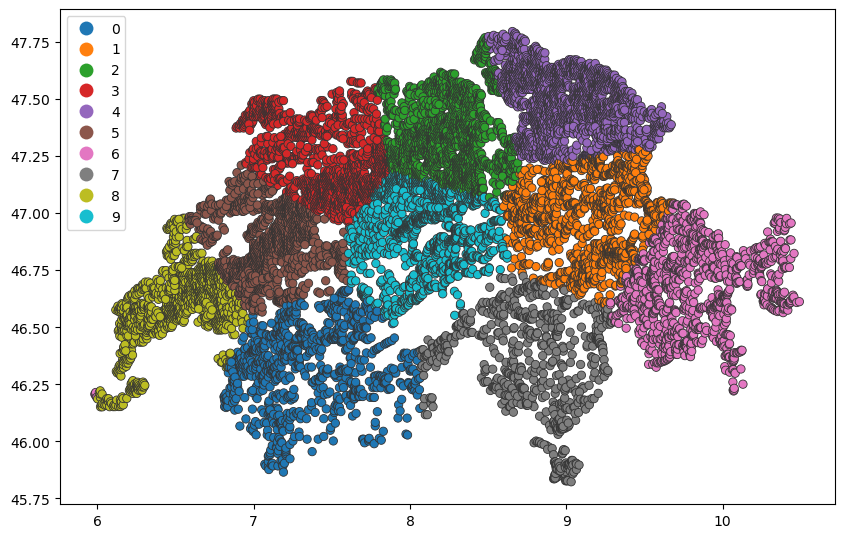

In [183]:
from sklearn.cluster import KMeans
import utm
import matplotlib.pyplot as plt

# Assuming `gdf` is your GeoDataFrame and it is in geographic coordinates (longitude, latitude)
gdf = gdf.to_crs(epsg=4326)  # ensure data is in lon/lat
geometry = gdf.geometry

# Extract latitude and longitude
coords = [(geom.y, geom.x) for geom in geometry]

# Convert lat/lon to UTM so that we can use Euclidean distance
utm_coords = [utm.from_latlon(coord[0], coord[1])[:2] for coord in coords]

# Run KMeans on UTM coordinate
kmeans = KMeans(n_clusters=10)  # adjust this parameter as needed
clusters = kmeans.fit_predict(utm_coords)

# Add cluster labels back to GeoDataFrame
gdf['cluster'] = clusters

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='cluster', categorical=True, legend=True, linewidth=0.6, edgecolor='0.2', ax=ax)
plt.show()


In [37]:
from ortools.linear_solver import pywraplp

# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')

# Create variables for each cluster
variables = {}
for cluster_id in gdf['cluster'].unique():
    if cluster_id == -1:
        continue  # skip the clusters with value -1

    # Create a binary variable to represent whether the cluster is selected or not
    variables[cluster_id] = solver.IntVar(0, 1, f'cluster_{cluster_id}')

# Constraint: Total production should be 1.2 TWh/yha or more
solver.Add(sum(variables[cluster_id] * gdf[gdf['cluster'] == cluster_id]['prod_MW'].sum() for cluster_id in variables) >= 1200000)

# The objective is to minimize the number of clusters.
solver.Minimize(solver.Sum(variables.values()))

# Call the solver and display the results.
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    print('Clusters selected:')
    for cluster_id, var in variables.items():
        if var.solution_value() > 0:
            print(f'Cluster ID: {cluster_id}, Total power output: {gdf[gdf["cluster"] == cluster_id]["prod_MW"].sum()}')
else:
    print('The problem does not have an optimal solution.')


The problem does not have an optimal solution.


### 4.1 Sort clusters from highest power output

In [20]:
# Sort clusters by total power output
cluster_outputs = {cluster_id: gdf[gdf['cluster'] == cluster_id]['prod_MW'].sum() for cluster_id in gdf['cluster'].unique() if cluster_id != -1}
sorted_clusters = sorted(cluster_outputs.items(), key=lambda item: item[1], reverse=True)

# Initialize total power output and selected clusters
total_output = 0
selected_clusters = []

# Iteratively add clusters until the power output constraint is met
for cluster_id, output in sorted_clusters:
    if total_output + output > 1.21*(10**6):
        continue
    total_output += output
    selected_clusters.append(cluster_id)

print('Total power output:', total_output)
print('Selected clusters:', selected_clusters)
print('Number of clusters needed: ', len(selected_clusters))


print('Total power output:', total_output)



[(68, 70518.27782345505), (54, 52721.95509172676), (69, 43067.96866629807), (48, 42320.59029004099), (43, 37250.781238291194), (58, 33201.14664511179), (71, 32011.056947410318), (57, 30903.823380849353), (66, 30486.921420566177), (70, 29049.695183319884), (67, 27154.455075555663), (51, 23546.487003884286), (59, 23445.526181896817), (33, 23112.815284037883), (25, 22938.373678937078), (46, 21645.463950004945), (53, 19417.090555554667), (9, 19089.293261027622), (21, 18549.793265784883), (11, 18364.220182419092), (60, 17761.07274707444), (40, 16209.129105028867), (42, 15691.509443127252), (27, 15014.397324441192), (39, 14954.775259969032), (50, 14314.873100121677), (6, 13744.351837849721), (29, 13432.776092391667), (23, 13121.995693366796), (35, 12778.22493845891), (28, 12261.861724321949), (55, 12030.569117203071), (44, 11791.970345008689), (64, 10815.25450645155), (22, 10165.992222025889), (19, 10065.532745428029), (32, 9968.764488744953), (49, 9932.470544843618), (26, 9831.463499979422)

## 5 Plausible Extensions


1. **Minimize Transmission Losses**: Once we've determined optimal locations for wind turbines, we could use similar optimization techniques to plan the routing of power transmission lines. By minimizing the total length of transmission lines or the number of transformations, you could reduce energy losses and costs.

    ```python
    # Graph `G` representing the power grid
    # and `selected_locations` from the previous optimization
    import networkx as nx
    G = nx.Graph()
    # Add edges to `G` here, with weights representing transmission losses or costs
    min_tree = nx.minimum_spanning_tree(G)
    ```

2. **Optimize Delivery of Wind Turbine Components**: Building wind turbines requires delivering large, heavy components to the construction site. You could use vehicle routing problem (VRP) techniques to plan these deliveries in a way that minimizes fuel consumption and emissions.

    ```python
    from ortools.constraint_solver import routing_enums_pb2
    from ortools.constraint_solver import pywrapcp

    # Create and configure a RoutingModel
    routing = pywrapcp.RoutingModel(tsp_size, num_vehicles, depot)
    search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    assignment = routing.SolveWithParameters(search_parameters)
    ```

3. **Maximize Energy Production While Minimizing Environmental Impact**: If you have data on bird migrations or other wildlife patterns, you could add constraints to your wind turbine placement optimization to avoid these areas. This would help maximize the energy production of your wind farm while minimizing its impact on wildlife.

4. **Optimize Maintenance Schedules**: Once the wind turbines are operational, they'll need regular maintenance. You could use similar optimization techniques to plan these maintenance schedules in a way that minimizes downtime and costs.

    ```python
    import pulp

    prob = pulp.LpProblem("Maintenance Scheduling Problem", pulp.LpMinimize)
    # Define your decision variables, objective function, and constraints here
    prob.solve()
    ```

5. **Predictive Maintenance**: Use machine learning techniques to predict when a wind turbine is likely to fail or need maintenance. This allows you to fix issues before they cause a problem, improving efficiency and reducing downtime. 

Remember, the quality of your results will depend heavily on the quality and granularity of your data. The more detailed and accurate data you have, the better results you'll be able to achieve.

## Watermark for programming environment

In [ ]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,seaborn,dbfread,ortools


Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.12.0

numpy     : 1.21.5
pandas    : 1.4.3
matplotlib: 3.7.1
seaborn   : 0.12.2
dbfread   : 2.0.7
ortools   : 9.6.2534

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

